In [5]:
import numpy as np
import scipy as sp
import pandas as pd
from scipy.signal import savgol_filter as svf
import matplotlib.pyplot as plt
from scipy.integrate import simps
from scipy.optimize import curve_fit
from matplotlib.animation import FuncAnimation
from matplotlib import animation
from IPython.display import HTML

In [6]:
cs = np.array(pd.read_csv('../Paroxetina_532nm_Edge_1800.csv'))
x, y = cs[:, 0], cs[:, 1]

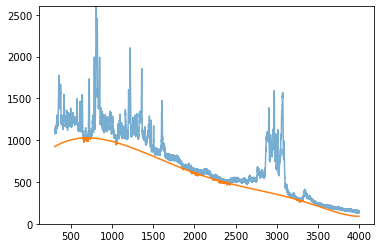

In [40]:
"""Baseline estimation algorithms."""

import numpy as np
import scipy.linalg as LA
import math



def baseline(y, deg=None, max_it=None, tol=None):
    """
    Computes the baseline of a given data.
    Iteratively performs a polynomial fitting in the data to detect its
    baseline. At every iteration, the fitting weights on the regions with
    peaks are reduced to identify the baseline only.
    Parameters
    ----------
    y : ndarray
        Data to detect the baseline.
    deg : int (default: 3)
        Degree of the polynomial that will estimate the data baseline. A low
        degree may fail to detect all the baseline present, while a high
        degree may make the data too oscillatory, especially at the edges.
    max_it : int (default: 100)
        Maximum number of iterations to perform.
    tol : float (default: 1e-3)
        Tolerance to use when comparing the difference between the current
        fit coefficients and the ones from the last iteration. The iteration
        procedure will stop when the difference between them is lower than
        *tol*.
    Returns
    -------
    ndarray
        Array with the baseline amplitude for every original point in *y*
    """
    # for not repeating ourselves in `envelope`
    if deg is None: deg = 3
    if max_it is None: max_it = 100
    if tol is None: tol = 1e-3
    
    order = deg + 1
    coeffs = np.ones(order)

    # try to avoid numerical issues
    cond = math.pow(abs(y).max(), 1. / order)
    x = np.linspace(0., cond, y.size)
    base = y.copy()

    vander = np.vander(x, order)
    vander_pinv = LA.pinv(vander)

    for _ in range(max_it):
        # multiplicar pontos pelos coeficientes da pseudo 
        # inversa matrix de Vandermonde para transformar o conjunto de pontos em um polinomio
        # Isso é realizado de maneira iterativa de modo a apagar os picos
        coeffs_new = np.dot(vander_pinv, y)

        if LA.norm(coeffs_new - coeffs) / LA.norm(coeffs) < tol:
        # Determina se a variação do valor dos coeficiente é menor do que o valor da tolerância.             
            break

        coeffs = coeffs_new
        # produto entre a matrix de vander e os coeficientes. Retorna o valor que cada ponto têm após a itereação.
        base = np.dot(vander, coeffs)
        # Pega o valor menor entre y e base e transforma o y novo nesse valor.
        y = np.minimum(y, base)
    return y

def envelope(y, deg=None, max_it=None, tol=None):
    """
    Computes the upper envelope of a given data.
    It is implemented in terms of the `baseline` function.
    
    Parameters
    ----------
    y : ndarray
        Data to detect the baseline.
    deg : int
        Degree of the polynomial that will estimate the envelope.
    max_it : int
        Maximum number of iterations to perform.
    tol : float
        Tolerance to use when comparing the difference between the current
        fit coefficients and the ones from the last iteration.
    Returns
    -------
    ndarray
        Array with the envelope amplitude for every original point in *y*
    """
    return y.max() - baseline(y.max() - y, deg, max_it, tol)

fig, ax = plt.subplots()
ax.clear()

def animate(i):
    ax.clear()
    ax.plot(x, y, alpha=.6)
    ax.plot(x, baseline(y, 5, i), scaley=False)
    ax.set_ylim(0,2600)
    

ani = FuncAnimation(fig, animate, frames=60, interval=100, repeat=False)
baseline_values = baseline(y, 5)
f = r"animation.gif" 
writergif = animation.PillowWriter(fps=30) 
ani.save(f, writer=writergif, dpi=300)
HTML(ani.to_html5_video())


In [46]:
f = r"animation.mp4" 
writervideo = animation.FFMpegWriter(fps=60) 
ani.save(f, writer=writervideo, dpi=300)



Primeiro plot

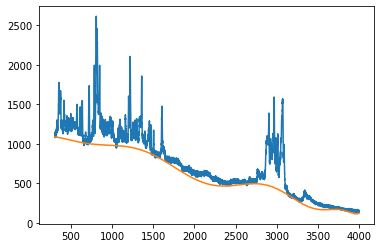

In [35]:
baseline_values = baseline(y, 10)
ax.clear()
ax.plot(x, y)
ax.plot(x, baseline_values)
fig

Remoção da baseline

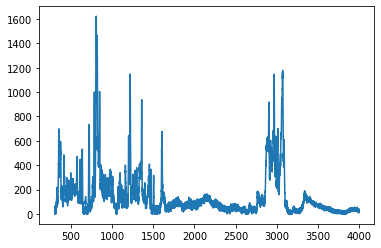

In [36]:
fig.clear()
subtracted_baseline = y-baseline_values
for i in range(len(subtracted_baseline)):
    if subtracted_baseline[i] < 0:
        subtracted_baseline[i] = 0

finaldata = np.array([x, subtracted_baseline])
finaldata = finaldata
plt.plot(finaldata[0], finaldata[1])

In [19]:
df = pd.DataFrame(finaldata.T, columns = ['x', 'y'])
df.to_csv('test.csv', header=False, index=False)